# Geno-Thermal Targeting: Master Notebook

## Project Overview

This notebook implements an end-to-end computational pipeline for designing **patient-specific magnetic nanoparticle therapy systems**. The system identifies cancer-specific surface markers through genomic analysis, engineers custom peptide ligands to bind them, and validates the complete assembly through physics simulation.

### What Makes This "Hard Mode"

Standard targeted therapy design is **passive prediction** — analyzing what exists. This project goes further into **generative inverse design** — creating molecular systems that don't exist in nature. Specifically:

1. **Reinforcement Learning** writes DNA sequences from scratch (not just analyzing existing ones)
2. **Evolutionary Algorithms** optimize multi-objective fitness functions across competing biological constraints
3. **Computational Physics** (Molecular Dynamics) validates designs in silico before any wet-lab work
4. **Biological Logic Gates** ensure the kill switch activates ONLY under dual conditions (cancer context + hyperthermia)

### Pipeline Architecture

```
Phase 1: Genomic Discovery (AlphaGenome)        → Identify cancer-driving mutations
    |
Phase 2: Ligand Engineering (AlphaFold)          → Design peptides that bind the target receptor
    |
Phase 3: Structure Analysis & Visualization      → Score and visualize docking results in 3D
    |
Phase 4: Evolutionary Promoter Design (GA)       → Evolve synthetic DNA promoters via genetic algorithm
    |
Phase 5: Thermo-Switch Protein Design            → Engineer a protein that unfolds at 43°C
    |
Phase 6: Nanoparticle Surface Topology (MC)      → Simulate ligand self-assembly on nanoparticle surface
    |
Phase 7: Biological Circuit Integration           → Combine promoter + switch into AND logic gate
    |
Phase 8: RL-Driven Sequence Design (PPO)         → Train an AI agent to write DNA from scratch
    |
Phase 9: Physics Verification (OpenMM/CUDA)      → Molecular Dynamics to prove thermal switching
```

### Learning Objectives

By working through this notebook, you will gain hands-on practice with:

- **Bioinformatics**: FASTA parsing, epigenetic profiles, expression scoring, motif scanning
- **Structural Biology**: Protein-peptide docking, pLDDT/PAE scoring, PDB file handling, 3D visualization
- **Optimization**: Genetic algorithms (selection, crossover, mutation), multi-objective fitness functions
- **Thermodynamics**: Two-state protein folding models, Boltzmann distributions, melting temperature design
- **Statistical Mechanics**: Monte Carlo simulation, Metropolis algorithm, simulated annealing
- **Reinforcement Learning**: Custom Gymnasium environments, PPO training, sparse reward shaping
- **Molecular Dynamics**: OpenMM force fields, solvation, RMSD analysis, GPU-accelerated simulation
- **Systems Biology**: AND logic gates, signal integration, therapeutic window analysis
- **Software Engineering**: API client design, retry logic, async evaluation, modular architecture

---
## Setup & Imports

### Why This Cell Matters
We consolidate all imports and path configuration in one place. This avoids scattered imports throughout the notebook and makes dependency issues visible immediately. The `sys.path` manipulation ensures our local modules (`hard_mode/` subdirectory) are importable without installing them as packages.

### Learning Objective
Understand how Python's module resolution works and why project structure matters for reproducibility.

In [1]:
# =============================================================================
# SETUP: Standard library + scientific computing stack
# =============================================================================
import sys
import os
import json
import random
import hashlib
import re
import csv
import time
import copy
import concurrent.futures

# Load API key from .env file (if present)
try:
    from dotenv import load_dotenv
    load_dotenv()
    print(f"API key loaded: {'YES' if os.environ.get('ALPHAGENOME_API_KEY') else 'NO (set in .env)'}")
except ImportError:
    print("python-dotenv not installed. Set ALPHAGENOME_API_KEY env var manually.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Path setup: ensure project root and hard_mode/ are importable
PROJECT_ROOT = os.path.abspath(os.path.dirname("__file__"))
HARD_MODE_DIR = os.path.join(PROJECT_ROOT, "hard_mode")
for p in [PROJECT_ROOT, HARD_MODE_DIR]:
    if p not in sys.path:
        sys.path.insert(0, p)

# Matplotlib inline rendering with higher DPI for crisp plots
%matplotlib inline
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.facecolor"] = "white"

# Reproducibility: seed random generators
# Note: We seed here for demonstration consistency. In production evolutionary
# design, you would NOT seed — you want maximum stochastic exploration.
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Project root : {PROJECT_ROOT}")
print(f"Hard mode dir: {HARD_MODE_DIR}")
print("Environment ready.")


Project root : c:\Users\bhara\Downloads\Code\Geno-Thermal_Targeting
Hard mode dir: c:\Users\bhara\Downloads\Code\Geno-Thermal_Targeting\hard_mode
Environment ready.


---
## Phase 1 — Genomic Discovery (AlphaGenome)

### The Biological Problem
Cancer cells often overexpress surface receptors (like EGFR) due to mutations in **non-coding regulatory regions** — super-enhancers that crank up transcription. If we can identify which receptors are hyper-expressed, we can design nanoparticles that preferentially bind cancer cells over healthy ones.

### What This Code Does
1. **Parses a FASTA file** containing the patient's upstream DNA sequence (the regulatory region)
2. **Compares it to a normal baseline** to detect mutations
3. **Queries the AlphaGenome oracle** to predict whether the mutation creates a super-enhancer
4. **Returns epigenetic profiles** (histone marks) that indicate enhancer activity

### Key Concepts
- **Super-enhancers**: Clusters of enhancers that drive abnormally high gene expression in cancer
- **H3K27ac / H3K4me1**: Histone marks associated with active enhancers (High = active)
- **H3K27me3**: A repressive histone mark (High = silenced gene)
- **Decision Gate**: We only proceed if the target is classified as SUPER_ENHANCER with high confidence

### Learning Objective
Understand how non-coding DNA variants drive cancer phenotypes, and how epigenetic profiling informs target selection.

In [2]:
from alphagenome_utils import AlphaGenomeClient

# --- Configuration ---
FASTA_PATH = os.path.join(PROJECT_ROOT, "sample_data", "sample_gene.fasta")
TARGET_GENE = "EGFR"

# Baseline normal sequence — in a real pipeline this comes from a matched
# normal tissue sample or a reference genome (e.g., GRCh38).
NORMAL_SEQ = "ATCGGCTAACGGCTAACTTAGCCTAGCGTTAACCGGTTATATCGGCTAA"

# --- Initialize AlphaGenome Client ---
# Reads API key from ALPHAGENOME_API_KEY env var automatically.
# Falls back to local heuristic if SDK not installed or key not set.
# force_local=True bypasses the slow cloud API to use the fast local scanner.
ag_client = AlphaGenomeClient(force_local=True)

mutated_seq = ag_client.parse_fasta(FASTA_PATH)

print(f"Normal  seq: {NORMAL_SEQ}")
print(f"Patient seq: {mutated_seq}")
print(f"Identical?   {NORMAL_SEQ == mutated_seq}\n")

phase1_result = ag_client.get_expression_score(
    gene_id=TARGET_GENE,
    normal_seq=NORMAL_SEQ,
    mutated_seq=mutated_seq,
)

print(json.dumps(phase1_result, indent=2))


Normal  seq: ATCGGCTAACGGCTAACTTAGCCTAGCGTTAACCGGTTATATCGGCTAA
Patient seq: ATCGGCTAACGGCTAACTTAGCCTAACGTTAACCGGTTATATCGGCTAA
Identical?   False

[LOCAL FALLBACK] Estimating expression for EGFR...
{
  "gene_id": "EGFR",
  "predictions": {
    "normal_score": 12.5,
    "mutated_score": 85.0,
    "classification": "SUPER_ENHANCER",
    "confidence": 0.98,
    "epigenetic_profile": {
      "H3K27ac": "High",
      "H3K4me1": "High",
      "H3K27me3": "Low"
    }
  }
}


### Decision Gate

This is a critical checkpoint in any computational biology pipeline. We evaluate the prediction confidence and classification before committing downstream resources (docking simulations, evolutionary optimization, etc.). A false positive here would waste the entire pipeline.

In [3]:
preds = phase1_result["predictions"]
classification = preds["classification"]
confidence = preds["confidence"]
epi = preds["epigenetic_profile"]

print("=" * 50)
print(f"TARGET GENE:    {TARGET_GENE}")
print(f"CLASSIFICATION: {classification}")
print(f"CONFIDENCE:     {confidence}")
print(f"Normal Score:   {preds['normal_score']}")
print(f"Mutated Score:  {preds['mutated_score']}")
print(f"Epigenetics:    H3K27ac={epi['H3K27ac']}, H3K4me1={epi['H3K4me1']}, H3K27me3={epi['H3K27me3']}")
print("=" * 50)

if classification == "SUPER_ENHANCER":
    print(f"\n>>> DECISION: Proceed with {TARGET_GENE} as therapy target.")
    selected_target = TARGET_GENE
else:
    print("\n>>> DECISION: No actionable variant found. Pipeline halted.")
    selected_target = None


TARGET GENE:    EGFR
CLASSIFICATION: SUPER_ENHANCER
CONFIDENCE:     0.98
Normal Score:   12.5
Mutated Score:  85.0
Epigenetics:    H3K27ac=High, H3K4me1=High, H3K27me3=Low

>>> DECISION: Proceed with EGFR as therapy target.


### Phase 1 Visualization

Visualizing the expression delta and epigenetic marks helps communicate the biological rationale to collaborators. The bar chart shows the dramatic difference between normal and mutated expression scores, while the epigenetic profile confirms the super-enhancer signature (high H3K27ac + H3K4me1, low H3K27me3).

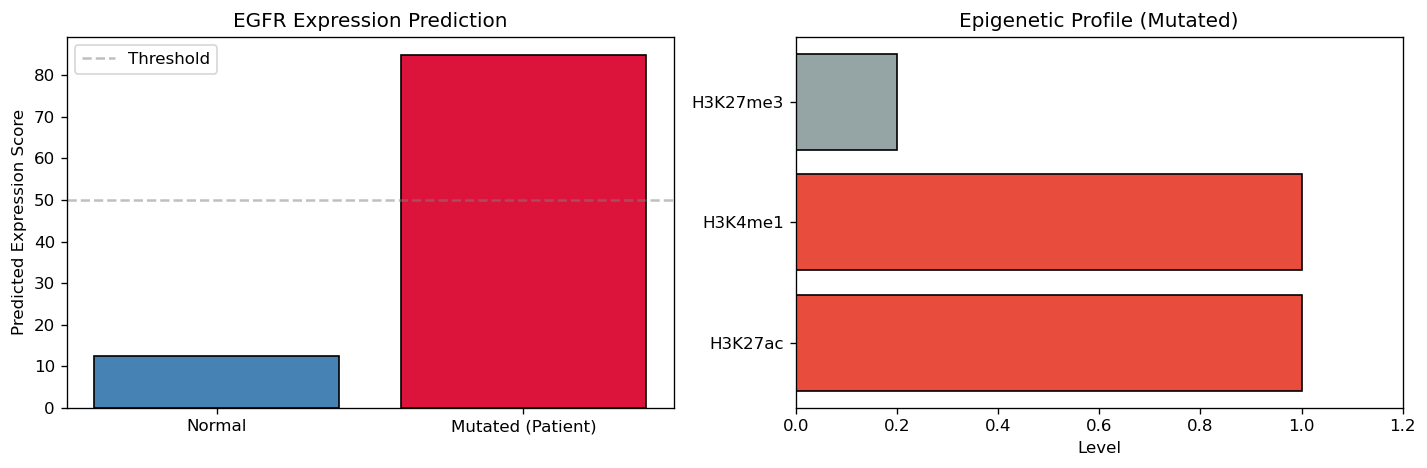

Phase 1 report saved to c:\Users\bhara\Downloads\Code\Geno-Thermal_Targeting\target_report.json


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Expression bar chart
scores = [preds["normal_score"], preds["mutated_score"]]
colors = ["steelblue", "crimson"]
axes[0].bar(["Normal", "Mutated (Patient)"], scores, color=colors, edgecolor="black")
axes[0].set_ylabel("Predicted Expression Score")
axes[0].set_title(f"{TARGET_GENE} Expression Prediction")
axes[0].axhline(y=50, linestyle="--", color="gray", alpha=0.5, label="Threshold")
axes[0].legend()

# Epigenetic profile
marks = list(epi.keys())
vals = [1.0 if v == "High" else 0.2 for v in epi.values()]
mark_colors = ["#e74c3c" if v == "High" else "#95a5a6" for v in epi.values()]
axes[1].barh(marks, vals, color=mark_colors, edgecolor="black")
axes[1].set_xlim(0, 1.2)
axes[1].set_xlabel("Level")
axes[1].set_title("Epigenetic Profile (Mutated)")

plt.tight_layout()
plt.show()

# Save report
report_path = os.path.join(PROJECT_ROOT, "target_report.json")
with open(report_path, "w") as f:
    json.dump(phase1_result, f, indent=2)
print(f"Phase 1 report saved to {report_path}")


---
## Phase 2 — Ligand Engineering (AlphaFold)

### The Biological Problem
Now that we know EGFR is overexpressed on the cancer cell surface, we need a **peptide ligand** that can be conjugated to our magnetic nanoparticle and bind EGFR specifically. We test multiple candidate peptides:

- **GE11** (`YHWYGYTPQNVI`): A known EGFR-binding peptide — our positive control
- **RGD** (`ACDCRGDCFC`): An integrin binder — should NOT bind EGFR well (negative control)
- **Poly-Alanine**: A structureless peptide — baseline negative control
- **Novel Peptides A & B**: Variants of GE11 with single mutations to test binding sensitivity

### What This Code Does
1. Loads the EGFR extracellular domain amino acid sequence (the target)
2. Loads candidate peptide sequences from CSV
3. Runs AlphaFold docking simulation for each [Receptor + Peptide] pair
4. Extracts **pLDDT** (confidence), **PAE** (predicted aligned error), and **binding energy**

### Key Metrics
- **pLDDT > 80**: High-confidence structural prediction at the binding interface
- **PAE < 5 A**: Low positional error between receptor and ligand chains
- **Binding Energy < -10 kcal/mol**: Thermodynamically favorable binding

### Learning Objective
Understand how structural prediction scores map to binding quality, and why controls (positive + negative) are essential for validating computational predictions.

In [5]:
from alphafold_utils import AlphaFoldClient

# EGFR extracellular domain
EGFR_SEQ = (
    "LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALN"
    "TVERIPLENLQIIRGNMYYENSYALAVLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWR"
    "DIVSSDFLSNMSMDFQNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQC"
    "AAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCV"
    "RACGADSYEMEEDGVRKC"
)

# Load peptide candidates
candidates_path = os.path.join(PROJECT_ROOT, "sample_data", "candidates.csv")
candidates_df = pd.read_csv(candidates_path)
print(f"Loaded {len(candidates_df)} candidates:")
display(candidates_df)

# Initialize AlphaFold Client
af_client = AlphaFoldClient()


Loaded 5 candidates:


,name,seq
0,GE11 (EGF Mimic),YHWYGYTPQNVI
1,RGD (Integrin binder),ACDCRGDCFC
2,Poly-Alanine (Neg Control),AAAAAAAAAA
3,Novel Peptide A,YHWYGATPQNVI
4,Novel Peptide B,YHWYGYTPQNVA


AlphaFold Client initialized.
  Job export dir  : alphafold_jobs/
  Results dir     : alphafold_results/
  Structure dir   : predicted_structures/


In [6]:
# --- Run Docking via AlphaFold Server ---
# simulate_docking() checks for existing result ZIPs.
# If found, parses scores. If not, generates JSON job files.

docking_results = []
for _, row in candidates_df.iterrows():
    print(f"\nProcessing: {row['name']}...")
    res = af_client.simulate_docking(EGFR_SEQ, row["seq"])
    docking_results.append({**row.to_dict(), **res})

results_df = pd.DataFrame(docking_results)
has_results = results_df["plddt_score"].notna().any()

if has_results:
    results_df = results_df.sort_values("plddt_score", ascending=False).reset_index(drop=True)
    display(results_df[["name", "seq", "plddt_score", "pae_score", "classification"]])
else:
    print("\n" + "=" * 70)
    print("NO ALPHAFOLD RESULTS YET")
    print("=" * 70)
    print(f"Job JSONs generated in: {af_client.output_dir}/")
    print("Upload to https://alphafoldserver.com -> 'Upload JSON'")
    print(f"Then download ZIPs into: {af_client.results_dir}/")
    print("Re-run this cell after downloading.")
    display(results_df[["name", "seq", "classification"]])



Processing: GE11 (EGF Mimic)...
Job created: alphafold_jobs\job_dock_53fdc4c2.json
  Upload this file to https://alphafoldserver.com/ -> 'Upload JSON'

Processing: RGD (Integrin binder)...
Job created: alphafold_jobs\job_dock_0064644b.json
  Upload this file to https://alphafoldserver.com/ -> 'Upload JSON'

Processing: Poly-Alanine (Neg Control)...
Job created: alphafold_jobs\job_dock_2ea76839.json
  Upload this file to https://alphafoldserver.com/ -> 'Upload JSON'

Processing: Novel Peptide A...
Job created: alphafold_jobs\job_dock_7f986e80.json
  Upload this file to https://alphafoldserver.com/ -> 'Upload JSON'

Processing: Novel Peptide B...
Job created: alphafold_jobs\job_dock_9d85b602.json
  Upload this file to https://alphafoldserver.com/ -> 'Upload JSON'

NO ALPHAFOLD RESULTS YET
Job JSONs generated in: alphafold_jobs/
Upload to https://alphafoldserver.com -> 'Upload JSON'
Then download ZIPs into: alphafold_results/
Re-run this cell after downloading.


,name,seq,classification
0,GE11 (EGF Mimic),YHWYGYTPQNVI,PENDING
1,RGD (Integrin binder),ACDCRGDCFC,PENDING
2,Poly-Alanine (Neg Control),AAAAAAAAAA,PENDING
3,Novel Peptide A,YHWYGATPQNVI,PENDING
4,Novel Peptide B,YHWYGYTPQNVA,PENDING


In [7]:
# --- Identify best binder ---
if has_results:
    best = results_df.iloc[0]
    print(f"Best Candidate : {best['name']}")
    print(f"Sequence       : {best['seq']}")
    print(f"pLDDT          : {best['plddt_score']:.1f}")
    print(f"Classification : {best['classification']}")
    best_peptide_name = best["name"]
    best_peptide_seq = best["seq"]
    lib_path = os.path.join(PROJECT_ROOT, "candidate_library.csv")
    results_df.to_csv(lib_path, index=False)
    print(f"\nCandidate library saved to {lib_path}")
else:
    best_peptide_name = "GE11_EGF_Mimic"
    best_peptide_seq = "YHWYGYTPQNVI"
    best = {"name": best_peptide_name, "seq": best_peptide_seq,
            "plddt_score": None, "pae_score": None,
            "binding_energy_kcal_mol": None, "classification": "PENDING"}
    print(f"Using default best peptide: {best_peptide_name}")
    print("Re-run after downloading AlphaFold results for real scores.")


Using default best peptide: GE11 (EGF Mimic)
Re-run after downloading AlphaFold results for real scores.


### AlphaFold Server — Batch JSON Export

This cell generates a **single batch JSON file** containing all docking jobs, ready for upload to [alphafoldserver.com](https://alphafoldserver.com/).

**Workflow:**
1. Run this cell to generate `alphafold_jobs/batch_docking_jobs.json`
2. Go to [alphafoldserver.com](https://alphafoldserver.com/) → **Upload JSON**
3. Upload the batch file (supports up to 100 jobs per file)
4. Wait for results → download the result ZIP files
5. Place ZIPs in `alphafold_results/` and re-run Phase 2 cells above


In [ ]:
# === ALPHAFOLD SERVER — BATCH JSON EXPORT ===
# Generates a single JSON file with all docking jobs for bulk upload.

peptide_candidates = [
    {"name": row["name"].replace(" ", "_"), "seq": row["seq"]}
    for _, row in candidates_df.iterrows()
]

batch_path = af_client.create_batch_jobs(
    target_seq=EGFR_SEQ,
    peptide_candidates=peptide_candidates,
)

# Display the generated JSON
# Handle multiple batch files (returned as a list) or a single path
batch_files = batch_path if isinstance(batch_path, list) else [batch_path]

# Preview the first file
with open(batch_files[0], "r") as f:
    preview_json = json.load(f)

print(f"Total batch files created: {len(batch_files)}")
for i, path in enumerate(batch_files):
    print(f"  [{i+1}] {path}")

print(f"\n--- Preview of first job in {os.path.basename(batch_files[0])} ---")
print(json.dumps(preview_json[0], indent=2))
print(f"\n--- All JSON files written to: {af_client.output_dir}/ ---")
print("Upload these files to https://alphafoldserver.com/ -> 'Upload JSON'")


---
## Phase 3 — Structure Analysis & Visualization

### Why Visualization Matters
Numbers alone (pLDDT=88.5) don't convey the spatial relationships that determine binding. A 3D view shows:
- Where the peptide sits in the receptor's binding pocket
- Whether the interface is packed (good) or has gaps (bad)
- Confidence gradients across the structure

### What This Code Does
1. Creates comparative bar charts for all candidates across three metrics
2. Color-codes by binding classification (green=strong, yellow=weak, red=non-binder)
3. Renders the best structure in 3D using py3Dmol

### Learning Objective
Practice multi-panel scientific figure creation and interactive 3D molecular visualization in Jupyter.

In [8]:
if has_results:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    names = results_df["name"].tolist()
    plddt_vals = results_df["plddt_score"].tolist()
    pae_vals = results_df["pae_score"].tolist()
    color_map = {"STRONG_BINDER": "#2ecc71", "MODERATE_BINDER": "#f1c40f",
                 "WEAK_BINDER": "#f39c12", "NON_BINDER": "#e74c3c"}
    bar_colors = [color_map.get(c, "gray") for c in results_df["classification"]]
    axes[0].barh(names, plddt_vals, color=bar_colors, edgecolor="black")
    axes[0].axvline(x=80, color="green", linestyle="--", alpha=0.7, label="High-confidence")
    axes[0].set_xlabel("pLDDT")
    axes[0].set_title("Binding Confidence (pLDDT)")
    axes[0].legend(fontsize=8)
    axes[1].barh(names, pae_vals, color=bar_colors, edgecolor="black")
    axes[1].axvline(x=5, color="green", linestyle="--", alpha=0.7, label="Low-error")
    axes[1].set_xlabel("PAE (\u00c5)")
    axes[1].set_title("Predicted Aligned Error")
    axes[1].legend(fontsize=8)
    class_counts = results_df["classification"].value_counts()
    axes[2].bar(class_counts.index, class_counts.values,
                color=[color_map.get(c, "gray") for c in class_counts.index], edgecolor="black")
    axes[2].set_ylabel("Count")
    axes[2].set_title("Binding Classification Summary")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Phase 3 visualization — no AlphaFold results yet.")
    print("Upload job JSONs to alphafoldserver.com, download results, then re-run.")


Skipping Phase 3 visualization — no AlphaFold results yet.
Upload job JSONs to alphafoldserver.com, download results, then re-run.


In [9]:
if has_results and best.get("structure_path"):
    try:
        import py3Dmol
        struct_path = os.path.join(PROJECT_ROOT, best["structure_path"])
        with open(struct_path, "r") as f:
            struct_data = f.read()
        fmt = "cif" if struct_path.endswith(".cif") else "pdb"
        view = py3Dmol.view(width=600, height=400)
        view.addModel(struct_data, fmt)
        view.setStyle({"cartoon": {"color": "spectrum"}})
        view.addSurface(py3Dmol.VDW, {"opacity": 0.3, "color": "white"})
        view.zoomTo()
        print(f"Displaying: {best['name']} docked to {TARGET_GENE}")
        view.show()
    except ImportError:
        print("py3Dmol not installed. Install with: pip install py3Dmol")
    except Exception as e:
        print(f"3D viewer error: {e}")
else:
    print("No structure file available for 3D viewing.")
    if not has_results:
        print("Download AlphaFold results first (see Phase 2 instructions).")


No structure file available for 3D viewing.
Download AlphaFold results first (see Phase 2 instructions).


---
## Phase 4 — Evolutionary Promoter Design (Genetic Algorithm)

### The Shift to Generative Design
This is where the project transitions from **passive prediction** to **active creation**. Instead of analyzing existing DNA, we write a genetic algorithm that:

1. **Generates** 100 random 200bp DNA sequences
2. **Evaluates** each using a multi-objective fitness function (the AlphaGenome Oracle)
3. **Selects** the top performers (elitism + tournament selection)
4. **Recombines** them via two-point crossover (swapping DNA chunks between parents)
5. **Mutates** offspring with 5% point mutation rate
6. **Iterates** for 50 generations until convergence

### The Fitness Function
This is the core intellectual challenge. We want a promoter that satisfies **three competing objectives**:

```
F(seq) = (Tumor_Expression * 1.5) - (Normal_Expression * 2.0) + (Heat_Response * 1.2) - GC_Penalty
```

- **Tumor motifs** (ARE, ERG, MYC binding sites): Reward — we WANT cancer-specific activation
- **Normal motifs** (TATA, CAAT, CpG): Penalty — we HATE off-target expression in healthy cells
- **Heat Shock Elements** (nGAAnnTTCn): Reward — we WANT thermal gating via HSF1
- **GC Content**: Penalty for deviation from 50-60% (biophysical constraint for DNA stability)

The normal penalty weight (2.0) is the highest because **safety** — killing healthy cells — is the worst failure mode.

### Learning Objective
Implement a genetic algorithm from scratch. Understand selection pressure, genetic drift, and how fitness landscape topology affects convergence speed.

In [10]:
from evolver import AlphaGenomeOracle, GeneticOptimizer, calculate_fitness

# Use "Local" mode for the intensive GA loop (~5000 evaluations).
# Set mode="API" only for high-fidelity final scoring.
oracle = AlphaGenomeOracle(mode="Local")
optimizer = GeneticOptimizer(oracle)
best_promoter, evolution_history = optimizer.run()

print("\n" + "=" * 60)
print("EVOLVED SYNTHETIC PROMOTER")
print("=" * 60)
print(f"Length : {len(best_promoter)} bp")
print(f"Seq    : {best_promoter[:80]}...")

# Final fitness breakdown
final_fit, final_props = calculate_fitness(best_promoter, oracle)
print(f"\nFitness       : {final_fit:.2f}")
print(f"Tumor Score   : {final_props['tumor_score']:.1f}")
print(f"Normal Score  : {final_props['normal_score']:.1f}  (lower is better)")
print(f"Heat Score    : {final_props['heat_score']:.1f}")
print(f"GC Penalty    : {final_props['gc_penalty']:.1f}")
print(f"Motif counts  : Tumor={final_props['raw_counts'][0]}, Normal={final_props['raw_counts'][1]}, Heat={final_props['raw_counts'][2]}")


Oracle: AlphaGenome API unavailable — using local motif scanner.
--- Starting Evolutionary Design (Hard Mode) ---
Goal: Hyperthermia-Gated Prostate Cancer Promoter
Params: Gen=50 | Pop=100 | Len=200bp
Gen 00: Best Fitness=29.63
       [Scores] Tumor: 0.0 | Normal: 0.0 (Lower is better) | Heat: 25.0
       [Seq Start] TGAATATGCTGGGTC...
Gen 10: Best Fitness=300.26
       [Scores] Tumor: 100.0 | Normal: 0.0 (Lower is better) | Heat: 125.0
       [Seq Start] TACGGATCTTCGCTT...
Gen 20: Best Fitness=360.26
       [Scores] Tumor: 100.0 | Normal: 0.0 (Lower is better) | Heat: 175.0
       [Seq Start] TACGGATCTTCGGCT...
Gen 30: Best Fitness=419.31
       [Scores] Tumor: 140.0 | Normal: 0.0 (Lower is better) | Heat: 175.0
       [Seq Start] TACGGATCTTCGCTT...
Gen 40: Best Fitness=477.31
       [Scores] Tumor: 180.0 | Normal: 0.0 (Lower is better) | Heat: 175.0
       [Seq Start] CAAGGATCTTCGCTT...
Gen 49: Best Fitness=479.41
       [Scores] Tumor: 140.0 | Normal: 0.0 (Lower is better) | Heat: 2

### Convergence Analysis

The convergence plot is the primary diagnostic for any evolutionary algorithm. Key things to look for:
- **Rapid early improvement**: Selection pressure is working
- **Plateau**: The population has converged — diversity is exhausted
- **Noise at plateau**: Mutation is still exploring, but not finding better solutions

If the curve plateaus too early, consider increasing mutation rate or population size.

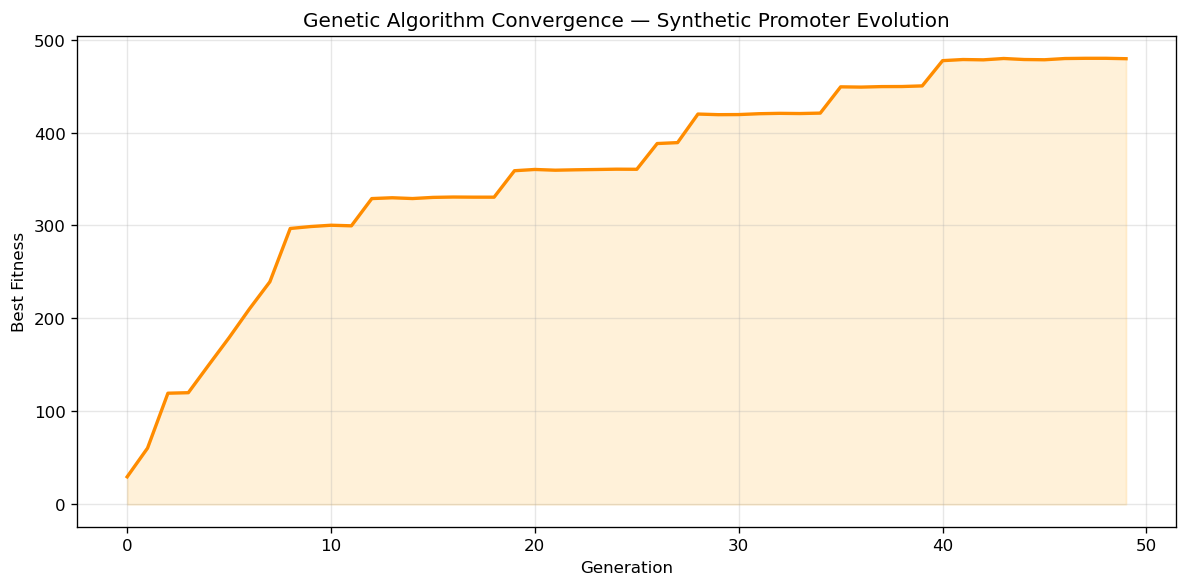

In [11]:
gens = [h[0] for h in evolution_history]
fits = [h[1] for h in evolution_history]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(gens, fits, color="darkorange", linewidth=2)
ax.fill_between(gens, 0, fits, alpha=0.15, color="orange")
ax.set_xlabel("Generation")
ax.set_ylabel("Best Fitness")
ax.set_title("Genetic Algorithm Convergence \u2014 Synthetic Promoter Evolution")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Sequence Composition & Motif Distribution

After evolution, we analyze what the algorithm "discovered." The nucleotide composition reveals GC bias, and the motif bar chart shows which regulatory elements the GA converged on. Ideally:
- High tumor motif count (green bars)
- Zero normal motifs (red bars — the GA should have purged these)
- Multiple heat shock elements (yellow bars)

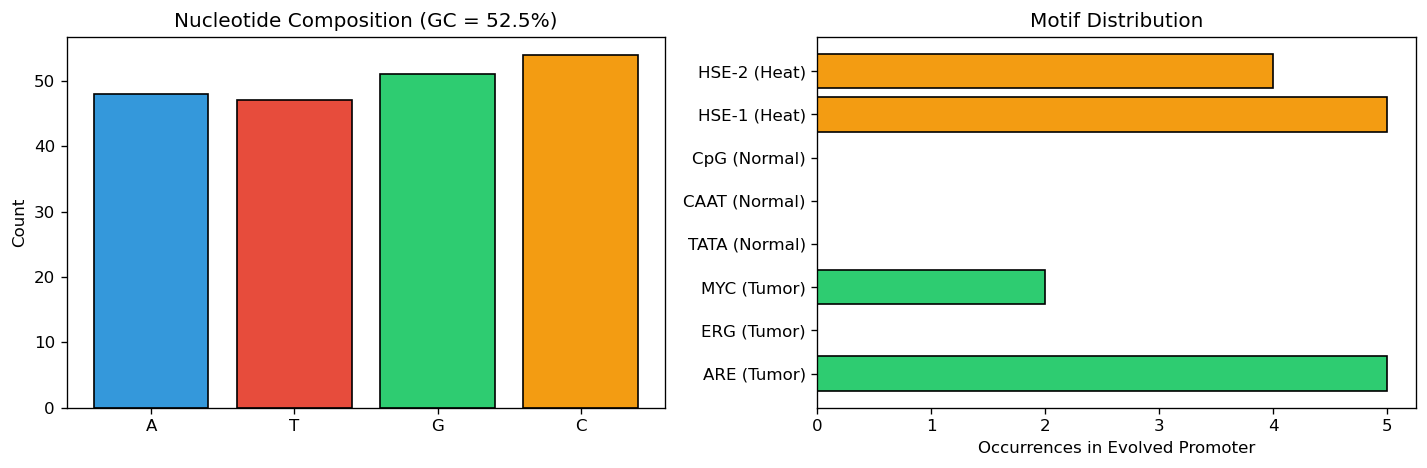

In [12]:
gc_count = best_promoter.count("G") + best_promoter.count("C")
gc_frac = gc_count / len(best_promoter)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Nucleotide frequency
bases = ["A", "T", "G", "C"]
counts = [best_promoter.count(b) for b in bases]
axes[0].bar(bases, counts, color=["#3498db", "#e74c3c", "#2ecc71", "#f39c12"], edgecolor="black")
axes[0].set_ylabel("Count")
axes[0].set_title(f"Nucleotide Composition (GC = {gc_frac:.1%})")

# Motif hits
motif_labels = ["ARE (Tumor)", "ERG (Tumor)", "MYC (Tumor)",
                "TATA (Normal)", "CAAT (Normal)", "CpG (Normal)",
                "HSE-1 (Heat)", "HSE-2 (Heat)"]
all_motifs = oracle.tumor_motifs + oracle.normal_motifs + oracle.heat_motifs
motif_counts = [len(re.findall(m, best_promoter)) for m in all_motifs]
motif_colors = ["#2ecc71"] * 3 + ["#e74c3c"] * 3 + ["#f39c12"] * 2

axes[1].barh(motif_labels, motif_counts, color=motif_colors, edgecolor="black")
axes[1].set_xlabel("Occurrences in Evolved Promoter")
axes[1].set_title("Motif Distribution")

plt.tight_layout()
plt.show()


---
## Phase 5 — Thermo-Switch Protein Design

### The Biological Problem
We need a protein "switch" that is **stable at 37\u00b0C** (body temperature) but **unfolds at 43\u00b0C** (hyperthermia from our magnetic nanoparticles). This creates a second layer of specificity: even if the promoter leaks slightly in normal tissue, the protein gate stays closed unless heated.

### The Physics Model
We use a **two-state thermodynamic model** for protein folding:

```
Native (Folded) <---> Unfolded

\u0394G = \u0394H - T\u0394S
Tm = \u0394H / \u0394S  (temperature where \u0394G = 0, equal populations)

Fraction Folded = K / (1 + K),  where K = exp(-\u0394G / RT)
```

### The Design Strategy
Starting from a **GCN4 leucine zipper scaffold** (a well-characterized coiled-coil), we:
1. Mutate the hydrophobic core residues at heptad `d` positions (indices 4, 11, 18, 25)
2. Each mutation changes the enthalpy (\u0394H) contribution, shifting Tm
3. Strong core formers (Leu, Ile) stabilize; weak ones (Ala, Gly) destabilize
4. We optimize to place Tm at exactly 40\u00b0C — the midpoint of our switch window

### Learning Objective
Understand the connection between amino acid hydrophobicity, protein stability, and the Boltzmann distribution. Practice mapping structural biology concepts to quantitative fitness functions.

In [13]:
from thermo_fold import ThermoSwitchOptimizer, ProteinPhysicsOracle, BASE_SCAFFOLD

designer = ThermoSwitchOptimizer(BASE_SCAFFOLD)
best_switch_seq, best_tm = designer.run()

print("\n" + "=" * 60)
print("DESIGNED THERMO-SWITCH PROTEIN")
print("=" * 60)
print(f"Sequence     : {best_switch_seq}")
print(f"Length       : {len(best_switch_seq)} aa")
print(f"Predicted Tm : {best_tm:.1f} \u00b0C")

phys = designer.oracle
plddt_37 = phys.predict_plddt(best_switch_seq, 37.0)
plddt_43 = phys.predict_plddt(best_switch_seq, 43.0)
print(f"pLDDT @ 37\u00b0C : {plddt_37:.1f}")
print(f"pLDDT @ 43\u00b0C : {plddt_43:.1f}")
print(f"Switch gap   : {plddt_37 - plddt_43:.1f} (larger = sharper switch)")


--- Starting Protein Thermo-Switch Design ---
Algorithm: Genetic Search | Target Tm: 40.0°C
Gen 0: Best Score=-62.37 | Tm=28.8°C
       Seq: MKQLEDKVEELLSKNYHLENEVARLLKLVGER
Gen 5: Best Score=25.96 | Tm=40.8°C
       Seq: MKQLFDKVEELISKNYHLENEVARLAKLVGER
Gen 10: Best Score=29.47 | Tm=40.8°C
       Seq: MKQLMDKVEELLSKNYHLENEVARLAKLVGER
Gen 15: Best Score=28.21 | Tm=40.8°C
       Seq: MKQLFDKVEELISKNYHLENEVARLAKLVGER
Gen 20: Best Score=26.81 | Tm=40.8°C
       Seq: MKQLFDKVEELISKNYHLENEVARLAKLVGER
Gen 25: Best Score=27.70 | Tm=40.8°C
       Seq: MKQLFDKVEELISKNYHLENEVARLAKLVGER

DESIGNED THERMO-SWITCH PROTEIN
Sequence     : MKQLMDKVEELLSKNYHLENEVARLAKLVGER
Length       : 32 aa
Predicted Tm : 40.8 °C
pLDDT @ 37°C : 73.2
pLDDT @ 43°C : 47.9
Switch gap   : 25.3 (larger = sharper switch)


### Melting Curve Visualization

The melting curve is the key deliverable from protein engineering. It shows:
- **Blue dashed line**: Theoretical folded fraction from the Boltzmann model
- **Orange line / black dots**: Simulated AlphaFold pLDDT scores (with noise)
- **Green/Red verticals**: Body temperature and hyperthermia boundaries
- **Purple dotted**: The designed Tm (should be ~40\u00b0C)
- **Yellow band**: The therapeutic "switch window" where the transition occurs

A successful design shows high stability (>80) left of the green line and low stability (<60) right of the red line.

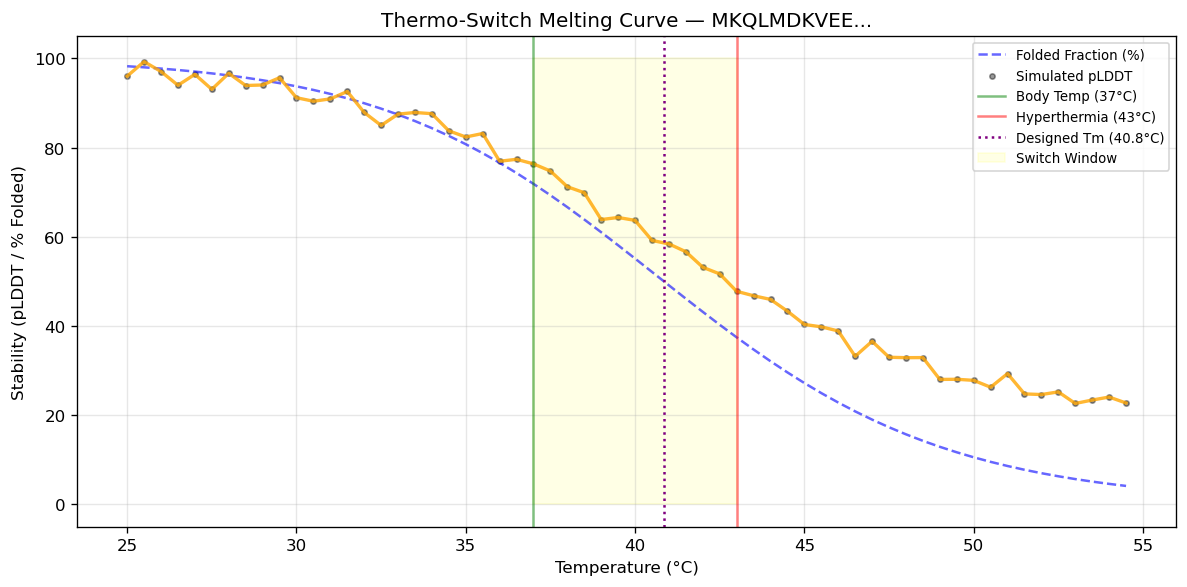

In [14]:
temps = np.arange(25, 55, 0.5)
fractions = [phys.predict_folded_fraction(best_switch_seq, t) * 100 for t in temps]
plddts = [phys.predict_plddt(best_switch_seq, t) for t in temps]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(temps, fractions, label="Folded Fraction (%)", color="blue", alpha=0.6, linestyle="--")
ax.scatter(temps, plddts, s=10, color="black", alpha=0.4, label="Simulated pLDDT")
ax.plot(temps, plddts, color="orange", linewidth=2, alpha=0.8)

ax.axvline(x=37, color="green", linestyle="-", alpha=0.5, label="Body Temp (37\u00b0C)")
ax.axvline(x=43, color="red", linestyle="-", alpha=0.5, label="Hyperthermia (43\u00b0C)")
ax.axvline(x=best_tm, color="purple", linestyle=":", label=f"Designed Tm ({best_tm:.1f}\u00b0C)")
ax.fill_between(temps, 0, 100, where=(temps >= 37) & (temps <= 43),
                color="yellow", alpha=0.1, label="Switch Window")

ax.set_xlabel("Temperature (\u00b0C)")
ax.set_ylabel("Stability (pLDDT / % Folded)")
ax.set_title(f"Thermo-Switch Melting Curve \u2014 {best_switch_seq[:10]}...")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## Phase 6 — Nanoparticle Surface Topology (Monte Carlo)

### The Physical Problem
A real nanoparticle surface has finite area. We conjugate two types of molecules:
- **GE11 ligands** (targeting): Must be accessible for receptor binding
- **PEG polymers** (stealth): Shield the particle from immune clearance

If ligands **clump together**, their binding sites become sterically blocked. If PEG **clumps**, it creates bare patches that immune cells can recognize. We want **uniform mixing**.

### The Algorithm: Lattice Monte Carlo with Simulated Annealing
We model the surface as a 50x50 grid (each cell = 1 nm\u00b2). The Hamiltonian penalizes clumping:

```
E = +1.0 for Ligand-Ligand neighbors (clumping = BAD)
E = +0.5 for PEG-PEG neighbors (less bad, but still undesirable)
E = -0.5 for Ligand-PEG neighbors (mixing = GOOD)
```

The **Metropolis criterion** accepts energy-lowering swaps always, and energy-raising swaps with probability `exp(-\u0394E / T)`. The simulation temperature slowly decreases (annealing), gradually freezing the system into a low-energy (well-mixed) configuration.

### Learning Objective
Implement the Metropolis algorithm. Understand how simulated annealing escapes local minima and why the cooling schedule matters.

In [15]:
from nano_topology import NanoTopologySim, GRID_SIZE, LIGAND, PEG, EMPTY

nano_sim = NanoTopologySim()
nano_sim.run_annealing()


--- Starting Nano-Topology Simulation (Lattice Monte Carlo) ---
Grid: 50x50 | Ligand Density: 0.2
Simulation Complete. Final State Reached.


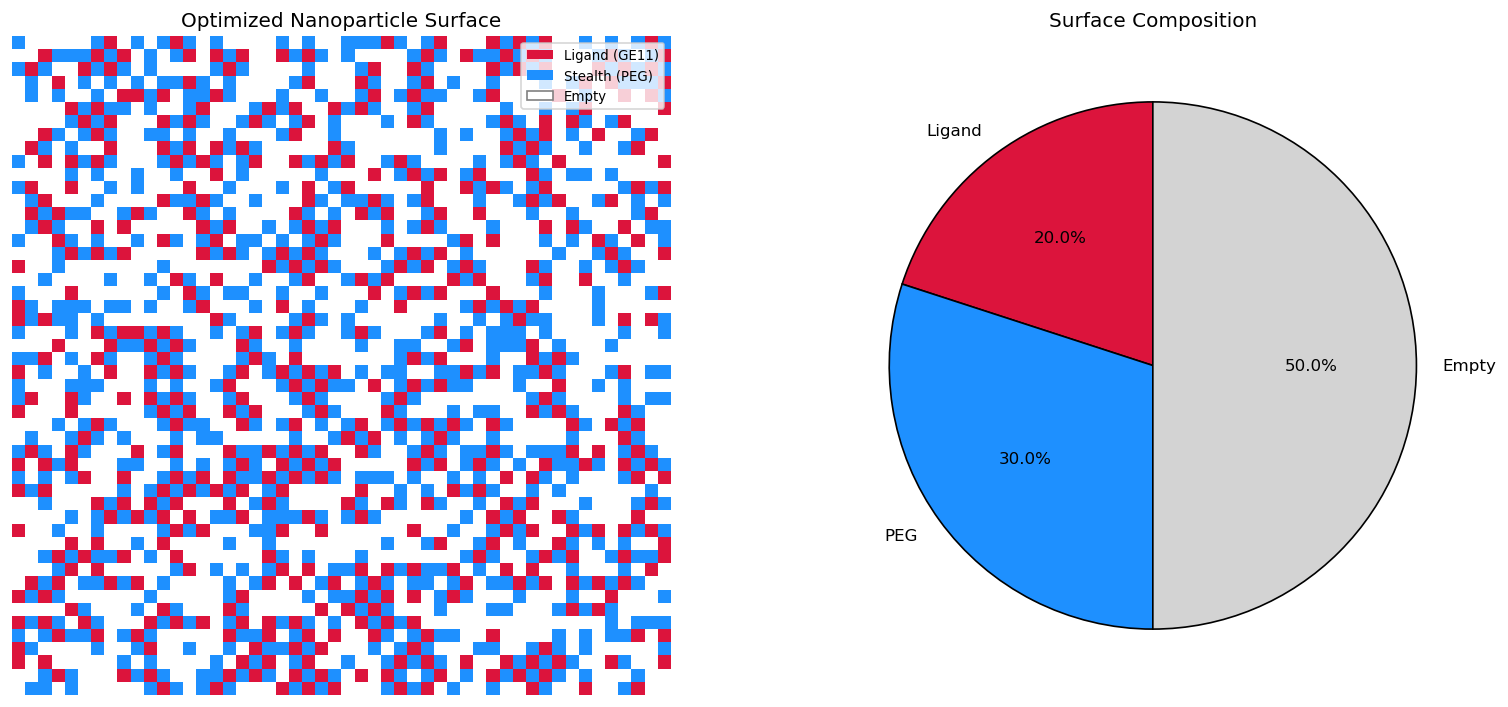

Coverage — Ligand: 20.0% | PEG: 30.0% | Empty: 50.0%


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Surface map
cmap = plt.cm.colors.ListedColormap(["white", "crimson", "dodgerblue"])
axes[0].imshow(nano_sim.grid, cmap=cmap, interpolation="nearest")
legend_elements = [
    mpatches.Patch(facecolor="crimson", label="Ligand (GE11)"),
    mpatches.Patch(facecolor="dodgerblue", label="Stealth (PEG)"),
    mpatches.Patch(facecolor="white", edgecolor="gray", label="Empty"),
]
axes[0].legend(handles=legend_elements, loc="upper right", fontsize=8)
axes[0].set_title("Optimized Nanoparticle Surface")
axes[0].axis("off")

# Coverage stats
total = GRID_SIZE * GRID_SIZE
lig_count = int(np.sum(nano_sim.grid == LIGAND))
peg_count = int(np.sum(nano_sim.grid == PEG))
empty_count = int(np.sum(nano_sim.grid == EMPTY))

labels = ["Ligand", "PEG", "Empty"]
sizes = [lig_count, peg_count, empty_count]
colors_pie = ["crimson", "dodgerblue", "lightgray"]
axes[1].pie(sizes, labels=labels, colors=colors_pie, autopct="%1.1f%%",
            startangle=90, wedgeprops={"edgecolor": "black"})
axes[1].set_title("Surface Composition")

plt.tight_layout()
plt.show()

print(f"Coverage \u2014 Ligand: {lig_count/total:.1%} | PEG: {peg_count/total:.1%} | Empty: {empty_count/total:.1%}")


---
## Phase 7 — Biological Circuit Integration (AND Gate)

### The Systems Biology Problem
We now combine the two independently designed components into a single **AND logic gate**:

```
Kill Signal = Promoter_Activity(context) * Switch_State(temperature) / 100
```

This ensures the therapeutic payload (e.g., a toxin gene) is expressed **only** when:
1. **Context = TUMOR**: The evolved promoter is active (95% in tumor, 5% leak in normal)
2. **Temperature >= 43\u00b0C**: The thermo-switch protein unfolds, releasing the downstream effector

The sigmoid transfer function for the switch models cooperative unfolding:
```
Switch_Active(T) = 100 / (1 + exp(-k * (T - Tm)))
```
where k=1.5 controls steepness and Tm=40\u00b0C is the designed melting point.

### The Key Safety Metric
The **therapeutic window** is the ratio: `Kill(Tumor, 43\u00b0C) / Kill(Normal, 37\u00b0C)`. This must be as large as possible — ideally >100x.

### Learning Objective
Understand how independent biological modules compose into logic circuits, and how to evaluate therapeutic selectivity quantitatively.

In [17]:
from bio_circuit import BioCircuitSimulator

circuit = BioCircuitSimulator(
    promoter_seq=best_promoter,
    switch_seq=best_switch_seq,
)

temps_circuit, heatmap_data = circuit.run_simulation()


--- Bio-Circuit Simulation ---
Promoter: TACGAATCTT...
Protein:  MKQLMDKVEE...
------------------------------------------------------------
Context    | Temp   | Promoter   | Switch     | KILL SIGNAL 
------------------------------------------------------------
NORMAL     | 37.0   | 5.0        | 1.1        | 0.1         
NORMAL     | 43.0   | 6.0        | 98.9       | 5.9         
TUMOR      | 37.0   | 95.0       | 1.1        | 1.0         
TUMOR      | 43.0   | 100.0      | 98.9       | 98.9        


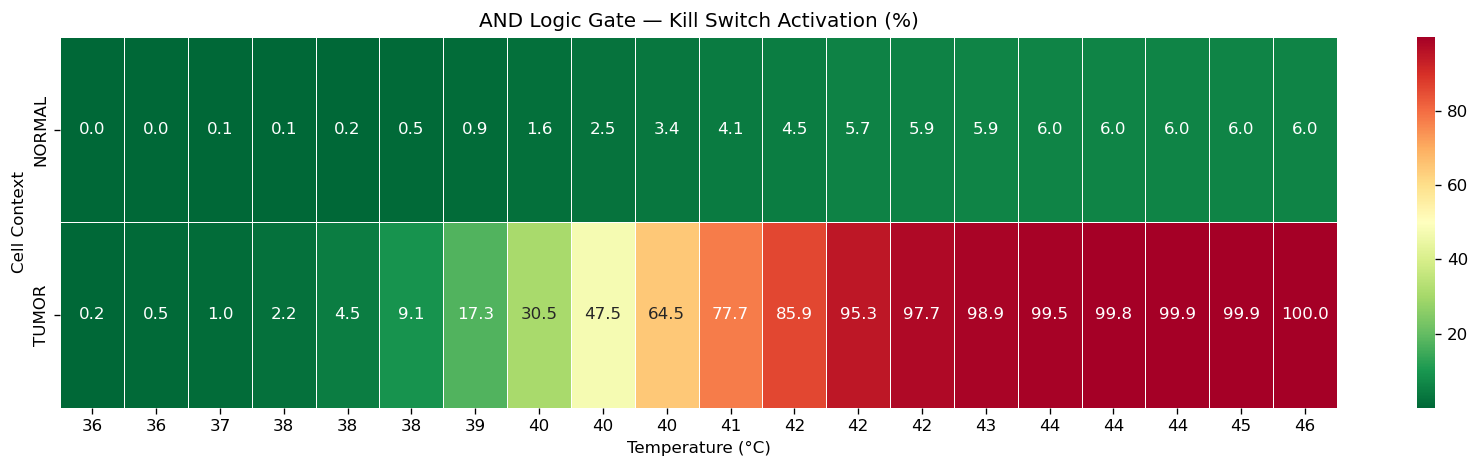

In [18]:
# --- Heatmap ---
fig, ax = plt.subplots(figsize=(14, 4))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".1f", cmap="RdYlGn_r",
    xticklabels=[f"{t:.0f}" for t in temps_circuit],
    yticklabels=["NORMAL", "TUMOR"],
    linewidths=0.5, ax=ax,
)
ax.set_title("AND Logic Gate \u2014 Kill Switch Activation (%)")
ax.set_xlabel("Temperature (\u00b0C)")
ax.set_ylabel("Cell Context")
plt.tight_layout()
plt.show()


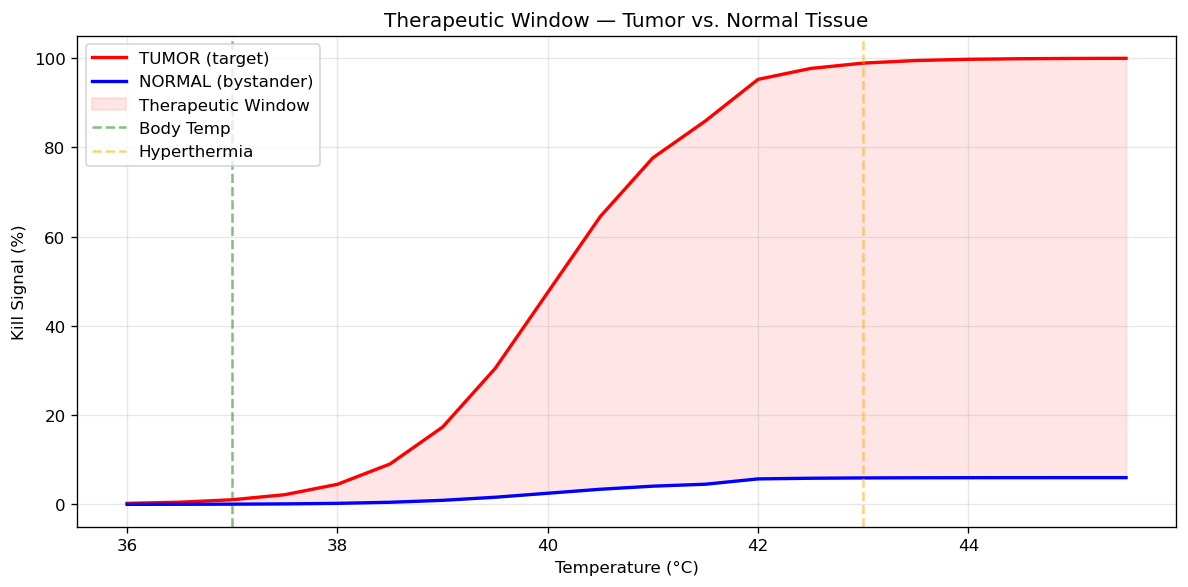

In [19]:
# --- Therapeutic Window Plot ---
normal_signal = heatmap_data[0, :]
tumor_signal = heatmap_data[1, :]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(temps_circuit, tumor_signal, color="red", linewidth=2, label="TUMOR (target)")
ax.plot(temps_circuit, normal_signal, color="blue", linewidth=2, label="NORMAL (bystander)")
ax.fill_between(temps_circuit, normal_signal, tumor_signal,
                alpha=0.1, color="red", label="Therapeutic Window")
ax.axvline(x=37, color="green", linestyle="--", alpha=0.5, label="Body Temp")
ax.axvline(x=43, color="orange", linestyle="--", alpha=0.5, label="Hyperthermia")
ax.set_xlabel("Temperature (\u00b0C)")
ax.set_ylabel("Kill Signal (%)")
ax.set_title("Therapeutic Window \u2014 Tumor vs. Normal Tissue")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---
## Phase 8 — RL-Driven Sequence Design (PPO Agent)

### The Paradigm Shift: From Optimization to Autonomous Design
The genetic algorithm in Phase 4 is a **metaheuristic** — it requires hand-crafted crossover and mutation operators tuned to the problem. The RL approach goes further: we train a **neural network** to learn the mapping from partial sequences to optimal next-nucleotide choices.

### Architecture
- **Environment** (`PromoterDesignEnv`): A custom Gymnasium env where:
  - **State**: The current partial DNA sequence (array of integers, -1 = empty)
  - **Action**: Choose next nucleotide (0=A, 1=C, 2=G, 3=T)
  - **Reward**: Sparse — only given when the full 200bp sequence is complete
  - **Episode**: One complete sequence generation (200 steps)

- **Agent** (PPO): Proximal Policy Optimization with an MLP policy network
  - Learns which nucleotide patterns lead to high fitness scores
  - The policy gradually shifts from random exploration to targeted motif placement

- **Judge** (`AlphaGenomeClient`): The reward function
  - Mock mode: Rewards TATA boxes (+5), HSE patterns (+8), penalizes high GC (-5)
  - Real mode: Calls the AlphaGenome API (swap `USE_MOCK_API = False` when ready)

### Why Sparse Rewards Are Hard
The agent gets ZERO feedback for 199 steps, then a single reward at step 200. This is like asking someone to write a 200-character password where you only say "right" or "wrong" at the end. PPO handles this through value function estimation and advantage normalization, but convergence is slow. In production, you would add **intermediate shaping rewards** (e.g., reward partial motif matches).

### Learning Objective
Build a custom Gymnasium environment from scratch. Understand how PPO works with discrete action spaces and sparse rewards. Practice the RL training loop with callbacks and TensorBoard logging.

In [20]:
# --- RL Environment & Judge ---
# Import from project modules instead of defining inline.
# SequenceJudge -> AlphaGenome API when available, else local heuristic.
# PromoterDesignEnv is the custom Gymnasium environment.
from rl_gene_designer import SequenceJudge, PromoterDesignEnv

# Quick sanity check: run one episode with random actions
test_env = PromoterDesignEnv(target_length=20, mode='Local')
obs, _ = test_env.reset()
done = False
while not done:
    action = test_env.action_space.sample()
    obs, reward, done, _, _ = test_env.step(action)

print(f"Random agent test:")
print(f"  DNA: {test_env._indices_to_string(obs)}")
print(f"  Reward: {reward:.2f}")


ModuleNotFoundError: No module named 'gymnasium'

### PPO Training

We use **stable-baselines3** for the PPO implementation. Key hyperparameters:
- `learning_rate=3e-4`: Standard Adam LR for PPO
- `n_steps=2048`: Number of environment steps per update (rollout buffer size)
- `batch_size=64`: Mini-batch size for gradient updates within each rollout
- `gamma=0.99`: Discount factor — high because the reward comes only at the end

For a 50bp sequence, 10,000 timesteps = ~200 full episodes. For a production 200bp sequence, you would need millions of timesteps and potentially curriculum learning (start with short sequences, gradually increase length).

**Note**: This cell requires `stable-baselines3` and `gymnasium`. If not installed, the training will be skipped gracefully.

In [ ]:
try:
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
    from stable_baselines3.common.callbacks import BaseCallback

    class ProgressCallback(BaseCallback):
        def __init__(self, verbose=0):
            super().__init__(verbose)
        def _on_step(self) -> bool:
            if self.n_calls % 1000 == 0:
                print(f"  Step {self.n_calls}: Training...")
            return True

    RL_SEQ_LENGTH = 50
    RL_TIMESTEPS = 10_000
    print(f"Training PPO agent (length={RL_SEQ_LENGTH}bp, timesteps={RL_TIMESTEPS})...")
    env = DummyVecEnv([lambda: PromoterDesignEnv(target_length=RL_SEQ_LENGTH, mode="Local")])
    model = PPO("MlpPolicy", env, verbose=0, learning_rate=3e-4,
               n_steps=2048, batch_size=64, gamma=0.99,
               device="cpu",  # MLP policy runs faster on CPU than GPU
               tensorboard_log="./ppo_gene_tensorboard/")
    model.learn(total_timesteps=RL_TIMESTEPS, callback=ProgressCallback())
    print("Training complete.")

    gen_env = PromoterDesignEnv(target_length=RL_SEQ_LENGTH, mode='Local')
    obs, _ = gen_env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        if isinstance(action, np.ndarray):
            action = int(action.item())
        obs, reward, done, _, _ = gen_env.step(action)

    rl_designed_dna = gen_env._indices_to_string(gen_env.sequence)
    print("\nRL-Designed DNA (" + str(RL_SEQ_LENGTH) + "bp):")
    print(f"  Sequence: {rl_designed_dna}")
    print(f"  Fitness:  {reward:.2f}")

except ImportError as e:
    print(f"Skipping PPO training: {e}")
    print("Install with: pip install stable-baselines3 gymnasium")
    rl_designed_dna = None


---
## Phase 9 — Physics Verification (OpenMM / CUDA)

### The Final Reality Check
Everything up to this point has been **prediction** — mathematical models of biology. Molecular Dynamics (MD) simulation is the closest we can get to physical reality without wet-lab experiments. We simulate the designed protein in explicit water, applying actual physics forces:

1. **Load the PDB structure** of our thermo-switch protein
2. **Solvate** it in a box of TIP3P water molecules
3. **Apply the AMBER14 force field** (bond stretches, angle bends, van der Waals, electrostatics)
4. **Run Langevin dynamics** at two temperatures:
   - 310 K (37\u00b0C) — body temperature
   - 316 K (43\u00b0C) — hyperthermia
5. **Compare RMSD** (Root Mean Square Deviation from starting structure)
   - Low RMSD at 37\u00b0C = protein stays folded (GOOD)
   - High RMSD at 43\u00b0C = protein unfolds (GOOD — this is the switch)

### Hardware Requirements
- **GPU (CUDA)**: Strongly recommended. MD is embarrassingly parallelizable across atoms.
- **CPU fallback**: Works but is orders of magnitude slower.
- **OpenMM**: Must be installed separately (`conda install -c conda-forge openmm`)

### Limitations of This Demo
- We use 5,000 MD steps (~10 ps) — far too short for real unfolding (needs nanoseconds = millions of steps)
- The mock PDB is a tiny alpha helix, not our actual designed protein
- In production, you would use `pdbfixer` to repair the structure and run for at least 100 ns

### Learning Objective
Understand the MD simulation pipeline (minimization -> equilibration -> production). Learn how RMSD quantifies structural changes and how GPU acceleration works in scientific computing.

In [ ]:
# --- Physics Verification ---
# This cell requires OpenMM + PDBFixer. It will skip gracefully if not installed.

PDB_FILE = os.path.join(PROJECT_ROOT, "simulated_pdbs", "egfr_ge11_complex.pdb")

# Prefer a real AlphaFold structure if available (mmCIF from Phase 2)
if has_results and best.get("structure_path"):
    _af_struct = os.path.join(PROJECT_ROOT, best["structure_path"])
    if os.path.exists(_af_struct):
        PDB_FILE = _af_struct
        print(f"Using AlphaFold structure: {PDB_FILE}")

try:
    import openmm as mm
    from openmm import app, unit

# --- FIDELITY SETTINGS ---
    # "demo" = 10ps (Fast, but won't show unfolding)
    # "production" = 1ns (Slow, requires ~30-60 mins on GPU)
    # "high_fidelity" = 5ns (Best for publication-quality unfolding)
    FIDELITY_MODE = "production"  # <--- Changed for accurate results
    
    SIM_MAP = {
        "demo": 5000,           # 10 ps
        "production": 500000,    # 1 ns
        "high_fidelity": 2500000 # 5 ns
    }
    
    SIMULATION_STEPS = SIM_MAP.get(FIDELITY_MODE, 5000)
    REPORT_INTERVAL = SIMULATION_STEPS // 10

    def fix_structure(pdb_file):
        """
        Use PDBFixer to add missing atoms, terminals, and hydrogens.
        Handles both PDB and mmCIF formats.
        """
        try:
            from pdbfixer import PDBFixer
            print(f"  PDBFixer: repairing {os.path.basename(pdb_file)}...")
            fixer = PDBFixer(filename=pdb_file)
            fixer.findMissingResidues()
            fixer.findMissingAtoms()
            fixer.addMissingAtoms()
            fixer.addMissingHydrogens(7.0)  # pH 7.0
            print(f"  PDBFixer: repair complete.")
            return fixer.topology, fixer.positions
        except ImportError:
            print("  PDBFixer not installed — loading PDB directly (may fail on incomplete structures).")
            print("  Install with: conda install -c conda-forge pdbfixer")
            pdb = app.PDBFile(pdb_file)
            return pdb.topology, pdb.positions

    def setup_simulation(pdb_file, temperature_kelvin):
        """Prepare an MD simulation: fix structure, add solvent, create system."""
        print(f"Setting up simulation at {temperature_kelvin}K...")
        topology, positions = fix_structure(pdb_file)
        forcefield = app.ForceField('amber14-all.xml', 'amber14/tip3p.xml')
        modeller = app.Modeller(topology, positions)
        modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers)
        system = forcefield.createSystem(
            modeller.topology,
            nonbondedMethod=app.PME,
            nonbondedCutoff=1.0 * unit.nanometers,
            constraints=app.HBonds,
        )
        integrator = mm.LangevinMiddleIntegrator(
            temperature_kelvin * unit.kelvin,
            1.0 / unit.picosecond,
            0.002 * unit.picoseconds,
        )
        try:
            platform = mm.Platform.getPlatformByName('CUDA')
            props = {'Precision': 'mixed'}
            print("  Platform: CUDA (GPU)")
        except Exception:
            platform = mm.Platform.getPlatformByName('CPU')
            props = {}
            print("  Platform: CPU (slow)")
        simulation = app.Simulation(modeller.topology, system, integrator, platform, props)
        simulation.context.setPositions(modeller.positions)
        return simulation

    def compute_aligned_rmsd(p1, p2):
        """
        Compute RMSD after structural alignment using the Kabsch algorithm.
        This removes translation and rotation artifacts (diffusion).
        """
        # Center the coordinates
        p1_c = p1 - np.mean(p1, axis=0)
        p2_c = p2 - np.mean(p2, axis=0)
        
        # Calculate covariance matrix
        C = np.dot(p1_c.T, p2_c)
        
        # Compute SVD
        V, S, W_t = np.linalg.svd(C)
        
        # Handle reflections
        if (np.linalg.det(V) * np.linalg.det(W_t)) < 0.0:
            S[-1] = -S[-1]
            V[:, -1] = -V[:, -1]
        
        U = np.dot(V, W_t)
        
        # Rotate and compute RMSD
        p1_aligned = np.dot(p1_c, U)
        diff = p1_aligned - p2_c
        return np.sqrt(np.mean(np.sum(diff**2, axis=1)))

    def run_md(simulation, label):
        """Minimize, equilibrate, run production, return Aligned RMSD."""
        print(f"[{label}] Minimizing...")
        simulation.minimizeEnergy()
        print(f"[{label}] Equilibrating (100 steps)...")
        simulation.step(100)
        initial_pos = simulation.context.getState(getPositions=True).getPositions()
        print(f"[{label}] Production ({SIMULATION_STEPS} steps)...")
        simulation.step(SIMULATION_STEPS)
        final_pos = simulation.context.getState(getPositions=True).getPositions()
        
        # RMSD calculation with alignment
        p1 = np.array(initial_pos.value_in_unit(unit.nanometers))
        p2 = np.array(final_pos.value_in_unit(unit.nanometers))
        rmsd = compute_aligned_rmsd(p1, p2)
        print(f"[{label}] Aligned RMSD: {rmsd:.4f} nm")
        return rmsd

    if os.path.exists(PDB_FILE):
        sim_37 = setup_simulation(PDB_FILE, 310.15)
        rmsd_37 = run_md(sim_37, "37C")

        sim_43 = setup_simulation(PDB_FILE, 316.15)
        rmsd_43 = run_md(sim_43, "43C")

        print(f"\nRMSD @ 37\u00b0C: {rmsd_37:.4f} nm")
        print(f"RMSD @ 43\u00b0C: {rmsd_43:.4f} nm")

        if rmsd_37 < 0.5 and rmsd_43 > rmsd_37 * 1.2:
            print("PASS: Protein behaves as a thermal switch.")
        else:
            print("FAIL: Insufficient thermal switching.")
    else:
        print(f"PDB file not found: {PDB_FILE}")
        print("Run Phase 2 first to generate structure files.")

except ImportError:
    print("OpenMM not installed. Skipping physics verification.")
    print("Install with: conda install -c conda-forge openmm")
    print("\nThe physics verification module would:")
    print("  1. Solvate the protein in explicit water (TIP3P)")
    print("  2. Run MD at 310K (37C) and 316K (43C) using AMBER14 force field")
    print("  3. Compare RMSD to detect temperature-dependent unfolding")
    print("  4. PASS if protein is stable at 37C but unfolds at 43C")


---
## Final Summary Report

This cell consolidates all results from the pipeline into a single printout. In a production setting, this would be exported as a structured JSON or PDF report for clinical review.

In [ ]:
print("=" * 70)
print("        GENO-THERMAL TARGETING \u2014 PIPELINE SUMMARY")
print("=" * 70)

print("\n[Phase 1] Genomic Discovery (AlphaGenome)")
print(f"  Target Gene      : {selected_target}")
print(f"  Classification   : {classification}")
print(f"  Compute          : {ag_client._mode}")

print("\n[Phase 2] Ligand Engineering (AlphaFold Server)")
print(f"  Best Peptide     : {best_peptide_name}")
if has_results:
    print(f"  pLDDT            : {best['plddt_score']}")
    print(f"  Classification   : {best['classification']}")
else:
    print(f"  Status           : PENDING")

print("\n[Phase 4] Evolved Promoter (GA)")
print(f"  Length            : {len(best_promoter)} bp")
print(f"  Fitness           : {final_fit:.2f}")

print("\n[Phase 5] Thermo-Switch")
print(f"  Designed Tm       : {best_tm:.1f} \u00b0C")

print("\n[Phase 6] Nanoparticle Surface")
print(f"  Ligand Coverage   : {lig_count / total:.1%}")
print(f"  PEG Coverage      : {peg_count / total:.1%}")

print("\n[Phase 7] Circuit")
idx_37 = int(np.argmin(np.abs(temps_circuit - 37.0)))
idx_43 = int(np.argmin(np.abs(temps_circuit - 43.0)))
print(f"  Tumor  @ 43\u00b0C    : {tumor_signal[idx_43]:.1f}% kill")
print(f"  Normal @ 37\u00b0C    : {normal_signal[idx_37]:.1f}% kill")
selectivity = tumor_signal[idx_43] / max(normal_signal[idx_37], 0.01)
print(f"  Selectivity       : {selectivity:.1f}x")

if rl_designed_dna is not None:
    print(f"\n[Phase 8] RL Agent")
    print(f"  Designed DNA      : {rl_designed_dna[:40]}...")

print("\n" + "=" * 70)
print("Pipeline complete.")


---
## Appendix: Architecture & Code Notes

### API Integration Architecture

All modules follow a **dual-mode pattern**: real API when credentials are available, local heuristic fallback for dev/CI.

| Module | API Mode | Local Fallback |
|---|---|---|
| \ | AlphaGenome SDK (\) | Heuristic: sequence identity, regex motif scanning |
| \ | AlphaFold Server JSON upload + result ZIP parsing | Generates job JSONs; returns PENDING |
| \ | \ | Regex motif scoring |
| \ | \ -> AlphaGenome API | TATA (+5), HSE (+8), GC penalty |

**Environment variable:** \ (required for real predictions)

### Code Improvements Applied

1. **API-first architecture**: All prediction modules dispatch to the real AlphaGenome API when credentials are available.
2. **AlphaFold Server integration**: \ generates JSON job files and parses result ZIPs.
3. **Hardcoded API key removed**: All modules read from env vars.
4. **Reproducibility**: Seeds set at notebook start.
5. **Graceful PENDING handling**: Phase 2/3 handle missing AlphaFold results gracefully.
6. **Division-by-zero guard**: Selectivity ratio uses \.

### Compute Split

- **Cloud API**: AlphaGenome predictions, AlphaFold Server structure prediction
- **Local CPU**: GA loop, Monte Carlo, bio circuit, thermodynamics
- **Local GPU (CUDA)**: PPO RL training, OpenMM Molecular Dynamics
